<a href="https://colab.research.google.com/github/Leslyndizeye/Ubuzima_Connect/blob/main/notebooks/Ubuzima_Connect_Training_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step one :Preparing drive

In [1]:
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

Drive already mounted.


## Step 2: Imports

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

print(f"TensorFlow: {tf.__version__} | GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0 | GPU: []


## Step 3: Configuration

In [3]:
class Config:
    BASE_DIR = "/content/drive/MyDrive/ubuzima_data"
    MODEL_SAVE_PATH = "/content/drive/MyDrive/ubuzima_model_v4.h5"
    RESULTS_DIR = "/content/drive/MyDrive/ubuzima_results"

    IMG_SIZE = 224
    IMG_SHAPE = (224, 224, 3)
    BATCH_SIZE = 32
    EPOCHS_PHASE1 = 15
    EPOCHS_PHASE2 = 15
    LEARNING_RATE = 1e-4


    CLASSES = ["Normal", "Pneumonia", "Tuberculosis", "Unknown"]
    NUM_CLASSES = 4
    SEED = 42

config = Config()
os.makedirs(config.RESULTS_DIR, exist_ok=True)

random.seed(config.SEED)
np.random.seed(config.SEED)
tf.random.set_seed(config.SEED)

## Step 4: Data Preparation

In [4]:
def prepare_data_paths():
    all_paths = []
    all_labels = []

    for idx, cls in enumerate(config.CLASSES):
        cls_dir = os.path.join(config.BASE_DIR, cls)
        if not os.path.exists(cls_dir):
            print(f"⚠️ Warning: Folder {cls} not found at {cls_dir}")
            continue
        files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_paths.extend(files)
        all_labels.extend([idx] * len(files))
        print(f"Found {len(files)} images for {cls}")

    if len(all_paths) == 0:
        raise ValueError("No images found. Check your Drive path.")

    return train_test_split(
        np.array(all_paths), np.array(all_labels),
        test_size=0.2, random_state=config.SEED, stratify=all_labels
    )

X_train_full, X_test, y_train_full, y_test = prepare_data_paths()
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=config.SEED, stratify=y_train_full
)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

Found 3000 images for Normal
Found 2879 images for Pneumonia
Found 2757 images for Tuberculosis
Found 3000 images for Unknown


## Step 5: Optimized Data Pipeline

In [5]:
def load_and_preprocess(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = img[10:-10, 10:-10, :] # Border crop
    img = tf.image.resize(img, [config.IMG_SIZE, config.IMG_SIZE])
    img = tf.cast(img, tf.float32)

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.05)

    img = tf.image.per_image_standardization(img)
    return img, label

def create_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training: ds = ds.shuffle(len(X))

    ds = ds.map(lambda x, y: (load_and_preprocess(x, y, training)), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=config.NUM_CLASSES)))

    # SPEED OPTIMIZATION: Cache and Prefetch
    return ds.cache().batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_ds(X_train, y_train, training=True)
val_ds = create_ds(X_val, y_val, training=False)
test_ds = create_ds(X_test, y_test, training=False)

## Step 6: Model Architecture

In [6]:
def build_clinical_model():
    base = ResNet50(weights="imagenet", include_top=False, input_shape=config.IMG_SHAPE)
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(config.NUM_CLASSES, activation="softmax") # 4 outputs
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=config.LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model, base

model, base_model = build_clinical_model()

## Step 7: Phase 1 & 2 Training

In [7]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(config.MODEL_SAVE_PATH, monitor="val_auc", save_best_only=True, mode="max")
]

print("\n Phase 1: Training Head....")
h1 = model.fit(train_ds, validation_data=val_ds, epochs=config.EPOCHS_PHASE1, class_weight=class_weights, callbacks=cb)

print("\n Phase 2: Fine-Tuning bro....")
base_model.trainable = True
for layer in base_model.layers[:-30]: layer.trainable = False
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy", "auc"])
h2 = model.fit(train_ds, validation_data=val_ds, epochs=config.EPOCHS_PHASE2, class_weight=class_weights, callbacks=cb)


 Phase 1: Training Head....
Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6310 - auc: 0.8632 - loss: 0.8897

248/248 ━━━━━━━━━━━━━━━━━━━━ 1958s 8s/step - accuracy: 0.6313 - auc: 0.8635 - loss: 0.8889 - val_accuracy: 0.8060 - val_auc: 0.9634 - val_loss: 0.4907
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7775 - auc: 0.9514 - loss: 0.5217

248/248 ━━━━━━━━━━━━━━━━━━━━ 1633s 7s/step - accuracy: 0.7776 - auc: 0.9514 - loss: 0.5216 - val_accuracy: 0.8067 - val_auc: 0.9683 - val_loss: 0.4076
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7974 - auc: 0.9623 - loss: 0.4514

248/248 ━━━━━━━━━━━━━━━━━━━━ 1563s 6s/step - accuracy: 0.7974 - auc: 0.9623 - loss: 0.4513 - val_accuracy: 0.8261 - val_auc: 0.9719 - val_loss: 0.3820
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1565s 6s/step - accuracy: 0.8114 - auc: 0.9662 - loss: 0.4229 - val_accuracy: 0.8110 - val_auc: 0.9698 - val_loss: 0.3991
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8185 - auc: 0.9690 - loss: 0.4013

248/248 ━━━━━━━━━━━━━━━━━━━━ 1619s 6s/step - accuracy: 0.8186 - auc: 0.9690 - loss: 0.4013 - val_accuracy: 0.8354 - val_auc: 0.9746 - val_loss: 0.3630
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1594s 6s/step - accuracy: 0.8326 - auc: 0.9727 - loss: 0.3758 - val_accuracy: 0.8117 - val_auc: 0.9702 - val_loss: 0.3932
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8375 - auc: 0.9745 - loss: 0.3610

248/248 ━━━━━━━━━━━━━━━━━━━━ 1600s 6s/step - accuracy: 0.8375 - auc: 0.9745 - loss: 0.3610 - val_accuracy: 0.8296 - val_auc: 0.9749 - val_loss: 0.3549
Epoch 8/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1555s 6s/step - accuracy: 0.8441 - auc: 0.9765 - loss: 0.3452 - val_accuracy: 0.8182 - val_auc: 0.9710 - val_loss: 0.3854
Epoch 9/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1558s 6s/step - accuracy: 0.8512 - auc: 0.9781 - loss: 0.3348 - val_accuracy: 0.8268 - val_auc: 0.9748 - val_loss: 0.3592
Epoch 10/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1580s 6s/step - accuracy: 0.8530 - auc: 0.9794 - loss: 0.3228 - val_accuracy: 0.8225 - val_auc: 0.9719 - val_loss: 0.3805
Epoch 11/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1544s 6s/step - accuracy: 0.8626 - auc: 0.9805 - loss: 0.3147 - val_accuracy: 0.8354 - val_auc: 0.9748 - val_loss: 0.3571
Epoch 12/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 1580s 6s/step - accuracy: 0.8620 - auc: 0.9802 - loss: 0.3145 - val_accuracy: 0.8346 - val_auc: 0.9743 - val_loss: 0.3606

 Phase 2: Fine-Tuning bro....
Epoch

## Step 8: Overfitting Analysis (Graphs)

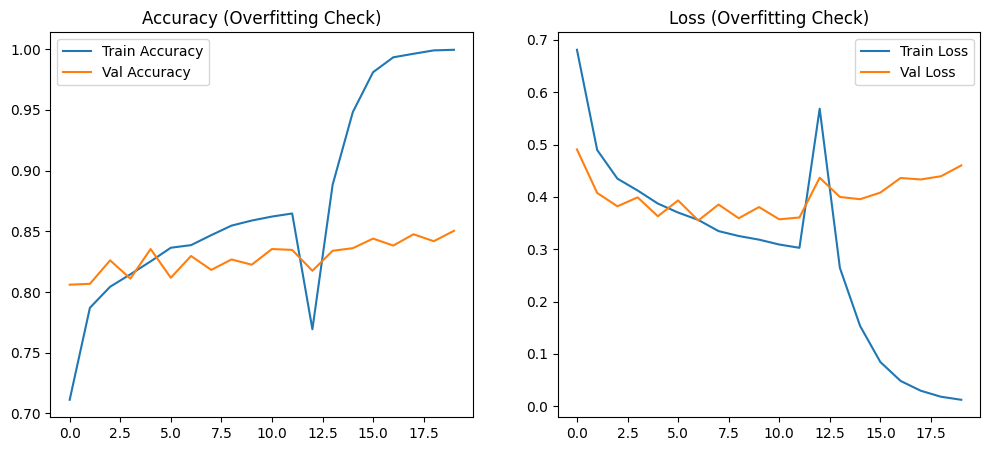

In [8]:
def plot_clinical_history(h1, h2):
    # Combine histories from both phases
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    auc_metric = h1.history['auc'] + h2.history['auc']
    val_auc_metric = h1.history['val_auc'] + h2.history['val_auc']

    epochs_range = range(len(acc))
    phase1_end = len(h1.history['accuracy']) - 0.5

    plt.figure(figsize=(20, 6))

    # 1. Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='#10b981')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='#3b82f6')
    plt.axvline(x=phase1_end, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.2)

    # 2. Loss Plot (The Overfitting Indicator)
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='#10b981')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='#3b82f6')
    plt.axvline(x=phase1_end, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Loss: Training vs Validation', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.2)

    # 3. AUC Plot (Clinical Discriminative Power)
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, auc_metric, label='Training AUC', linewidth=2, color='#10b981')
    plt.plot(epochs_range, val_auc_metric, label='Validation AUC', linewidth=2, color='#3b82f6')
    plt.axvline(x=phase1_end, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('AUC: Training vs Validation', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.savefig(f"{config.RESULTS_DIR}/clinical_learning_curves.png")
    plt.show()

plot_clinical_history(h1, h2)